# Sentiment Analysis with LSTMs using Keras
## Deep Learning (18CSE484T) Group Project

### Group Members:

- Bhavesh Laddagiri (RA1911026030032)
- Akshaj Vishwanathan (RA1911026030003)
- Hardik Gupta (RA1911026030027)

## Requirements
- Tensorflow
- HuggingFace Datasets (`pip install datasets`)
- Numpy
- Pandas

In [1]:
pip install datasets numpy==1.19.5

     |████████████████████████████████| 312 kB 29.5 MB/s eta 0:00:01
     |████████████████████████████████| 14.9 MB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 26.7 MB 73.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 72.2 MB/s eta 0:00:01
     |████████████████████████████████| 76 kB 6.3 MB/s  eta 0:00:01
     |████████████████████████████████| 134 kB 72.8 MB/s eta 0:00:01
     |████████████████████████████████| 86 kB 8.6 MB/s  eta 0:00:01
     |████████████████████████████████| 212 kB 77.1 MB/s eta 0:00:01
     |████████████████████████████████| 128 kB 94.4 MB/s eta 0:00:01
     |████████████████████████████████| 67 kB 462 kB/s  eta 0:00:01
     |████████████████████████████████| 121 kB 76.9 MB/s eta 0:00:01
     |████████████████████████████████| 308 kB 29.1 MB/s eta 0:00:01
     |████████████████████████████████| 158 kB 67.6 MB/s eta 0:00:01
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.59.0
    Uninstalling tqdm-4.59.0:
 

In [20]:
import numpy as np
import pandas as pd
from datasets import Dataset
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Dataset

Sentiment140 Dataset https://www.kaggle.com/kazanova/sentiment140

In [14]:
full_dataset = pd.read_csv('data/training.1600000.processed.noemoticon.csv', 
                           encoding="ISO-8859-1", 
                           names=["sentiment", "ids", "date", "flag", "user", "text"])

In [15]:
dataset = Dataset.from_pandas(full_dataset[['sentiment', 'text']])

In [16]:
dataset

Dataset({
    features: ['sentiment', 'text'],
    num_rows: 1600000
})

In [17]:
def fix_labels(row):
    '''Convert (0 = negative, 4 = positive) to (0, 1) respectively'''
    row['sentiment'] = [0 if s == 0 else 1 for s in row['sentiment']]
    return row

dataset = dataset.map(fix_labels, batched=True)

  0%|          | 0/1600 [00:00<?, ?ba/s]

In [18]:
# Check lengths of text
text_lengths = list(map(lambda x: len(x.split()), dataset['text']))

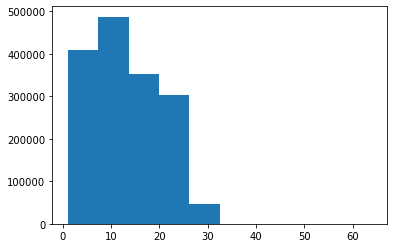

In [21]:
plt.hist(text_lengths)
plt.show()

In [22]:
print('Mean Num Words in Texts:', np.mean(text_lengths))
print('Median Num Words in Texts:', np.median(text_lengths))
print('Max Num Words in Texts:', np.max(text_lengths))
print('Min Num Words in Texts:', np.min(text_lengths))

Mean Num Words in Texts: 13.176150625
Median Num Words in Texts: 12.0
Max Num Words in Texts: 64
Min Num Words in Texts: 1


In [23]:
dataset_splits = dataset.train_test_split(test_size=0.5, seed=10)
train_data = dataset_splits['train'].to_pandas()
test_data = dataset_splits['test'].to_pandas()

<AxesSubplot:>

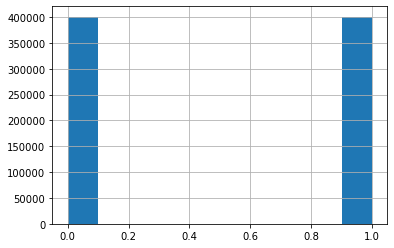

In [24]:
# Check the balance of labels
train_data['sentiment'].hist()

In [25]:
vocab_size = 100000
maxlen = 40

In [26]:
# Create a tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<UNK>')

In [27]:
# Fit the tokenizer to the training data
tokenizer.fit_on_texts(train_data['text'])

In [28]:
# Get the vocabulary dictionary
vocab = tokenizer.word_index

In [29]:
def preprocess_text(texts, tokenizer, maxlen):
    '''Preprocess a list of text sequences'''
    # convert string to sequence of integers based on vocab
    sequences = tokenizer.texts_to_sequences(texts)
    
    # pad sequences to fixed length
    padded = pad_sequences(sequences, maxlen=maxlen, truncating='post', padding='post')
    
    return padded

In [30]:
X_train = preprocess_text(train_data['text'], tokenizer, maxlen)
X_test = preprocess_text(test_data['text'], tokenizer, maxlen)

In [31]:
X_train.shape

(800000, 40)

In [32]:
X_test.shape

(800000, 40)

In [33]:
y_train = train_data['sentiment'].values
y_test = test_data['sentiment'].values

In [34]:
y_train.shape

(800000,)

In [35]:
y_test.shape

(800000,)

## Build Model

In [36]:
embedding_dim = 64

In [45]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [46]:
model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=0.0008), 
              metrics=['accuracy'])

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 64)            6400000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 6,412,961
Trainable params: 6,412,961
Non-trainable params: 0
_________________________________________________________________


## Train Model

In [48]:
num_epochs = 2
batch_size = 256

In [49]:
history = model.fit(
    X_train, 
    y_train, 
    batch_size=batch_size, 
    epochs=num_epochs, 
    validation_data=(X_test, y_test),
)

Epoch 1/2
3125/3125 [==============================] - 120s 38ms/step - loss: 0.4895 - accuracy: 0.7467 - val_loss: 0.4035 - val_accuracy: 0.8162
Epoch 2/2
3125/3125 [==============================] - 114s 36ms/step - loss: 0.3670 - accuracy: 0.8355 - val_loss: 0.4021 - val_accuracy: 0.8198


In [50]:
# save model
model.save('model-twitter.h5')

In [51]:
# save tokenizer
with open('tokenizer-twitter.json', 'w') as f:
    f.write(tokenizer.to_json())

## Inference

In [52]:
# load model and tokenizer
model = keras.models.load_model('model-twitter.h5')

with open('tokenizer-twitter.json', 'r') as f:
    tokenizer = keras.preprocessing.text.tokenizer_from_json(f.read())

In [53]:
sample_text = "CellStrat Hub is such a cool deployment platform."

In [54]:
seq = preprocess_text([sample_text], tokenizer, maxlen)

In [55]:
model.predict(seq)

array([[0.96188724]], dtype=float32)